In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [13]:
def parse_minutes(x):
    
    spl = x.split('.')[0].split(' ')
    hours = int(spl[0]) * 60
    mins = int(spl[2]) if spl[2] != '' else 0
    return hours + mins

def read_map(P1, P2, induction_lvl=6, ctrl_replicate=2):
    
    plate_map_builder = [[P1] * 6 + [P2] * 6 for _ in range(6)]
    plate_map_builder.append([None] * 12)
    plate_map_builder.append([None, None, 'BK', 'BK', '3K3-N', '3K3-N', 'BA', 'BA', '4A3-N', '4A3-N', '4A3-P', '4A3-P'])
    plate_map = pd.concat([pd.Series(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']),
               pd.DataFrame(np.array(plate_map_builder))], axis=1)
    plate_map.columns = ['group', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['group'].apply(lambda x: str(ord(x)- 65))) + ((plate_map['variable'] - 1) % induction_lvl).astype(str)
    plate_map.loc[plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['variable'] - 1) % ctrl_replicate
    return plate_map[['Well', 'value', 'suffix']].dropna()

def generate_metadata(well, plate_map):
    
    dictionary = pd.read_csv('datasets/dictionary.csv')
    sample_map = pd.Series(dictionary['short_name'].values, index=dictionary['id']).to_dict()
    sample_map.update({
        'BK': 'blank-kan',
        'BA': 'blank-amp',
        '3K3-N': 'negative-control-kan',
        '4A3-N': 'negative-control-amp',
        '4A3-P': 'positive-control-amp'
    })
    #sample_map.update(control_map)
    df = pd.merge(well, plate_map, on='Well', how='left').dropna(subset=['value']).reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(str)
    return df.dropna()

def transpose_data(df, col):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index()
    df['time'] = df['index'].apply(parse_minutes)
    df = df.set_index('time').drop('index', axis=1)
    return df

def generate_data(df, name, h=24, m=0, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data+1):
        idxs.append(h * 3 + idxs[i-1] + 1 + int(m/20))
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data, blanks):
    
    blank_avg = data[blanks].mean(axis=1)
    return data.sub(blank_avg, axis=0)

def get_neg_ctrl_corrected(fluo, od, blanks, neg_ctrls):
    
    blank_corr_fluo = get_blank_corrected(fluo, blanks)
    blank_corr_od = get_blank_corrected(od, blanks)
    data = blank_corr_fluo / blank_corr_od
    neg_avg = data[neg_ctrls].mean(axis=1)
    return data.sub(neg_avg, axis=0)

#### 001-002

In [15]:
folder = '033-all-and-gates-characterization'
P1, P2 = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder)).iloc[0].tolist()
plate_map = read_map(P1, P2)
raw_data = pd.read_csv('datasets/experiment/{}/001-002.csv'.format(folder), skiprows=[0])
metadata = generate_metadata(raw_data['Well'], plate_map)
data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
datas = generate_data(data, metadata['short_name'], h=24, m=0, num_data=8)

In [4]:
ctrl = ['blank-kan', 'blank-amp', 'negative-control-kan', 'negative-control-amp', 'positive-control-amp']

sample_blank = data[filter(lambda x: x.startswith('blank-kan'), data.columns)]
sample_ctrl = data[filter(lambda x: x.startswith('blank-kan'), data.columns)]
 = ['negative-control-kan_0', 'negative-control-kan_1']
rep_blank = ['blank-amp_0', 'blank-amp_1']
rep_ctrl = ['negative-control-amp_0', 'negative-control-amp_1']
rep = ['positive-control-amp_0', 'positive-control-amp_1']

df = get_neg_ctrl_corrected(datas[5], datas[4], ['blank-kan_0', 'blank-kan_1'], )

In [31]:
datas[1].iloc[:,-10:]

short_name,blank-kan_0,blank-kan_1,negative-control-kan_0,negative-control-kan_1,blank-amp_0,blank-amp_1,negative-control-amp_0,negative-control-amp_1,positive-control-amp_0,positive-control-amp_1
time,,,,,,,,,,
0,NaN,NaN,96.0,-106.0,NaN,NaN,61.0,25.0,789.0,677.0
20,NaN,NaN,68.0,-45.0,NaN,NaN,73.0,51.0,361.0,311.0
40,NaN,NaN,92.0,-139.0,NaN,NaN,37.5,23.5,439.5,409.5
60,NaN,NaN,76.0,-50.0,NaN,NaN,36.0,27.0,614.0,656.0
80,NaN,NaN,16.5,-105.5,NaN,NaN,17.5,22.5,823.5,782.5
100,NaN,NaN,37.5,-169.5,NaN,NaN,-8.0,-41.0,959.0,1010.0
120,NaN,NaN,73.0,-120.0,NaN,NaN,58.5,-0.5,1222.5,1183.5
140,NaN,NaN,52.0,-71.0,NaN,NaN,44.0,56.0,1430.0,1507.0
160,NaN,NaN,95.5,-89.5,NaN,NaN,110.5,97.5,1882.5,1881.5


In [16]:
fluo = datas[1].iloc[18][filter(lambda x: x.startswith('e11x32NrdA2'), datas[1].iloc[18].index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
fluo_t
#fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
#sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')

,gate,360,cuma,ara
0,e11x32NrdA2_00,-49.5,0,0
1,e11x32NrdA2_01,-186.5,0,1
2,e11x32NrdA2_02,-370.5,0,2
3,e11x32NrdA2_03,-433.5,0,3
4,e11x32NrdA2_04,-522.5,0,4
5,e11x32NrdA2_05,-645.5,0,5
6,e11x32NrdA2_10,203.5,1,0
7,e11x32NrdA2_11,4098.5,1,1
8,e11x32NrdA2_12,4587.5,1,2
9,e11x32NrdA2_13,4735.5,1,3


<AxesSubplot:xlabel='None-ara', ylabel='cuma'>

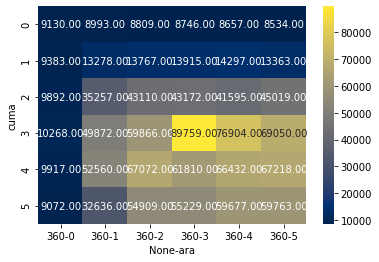

In [6]:
fluo = datas[5].iloc[18][filter(lambda x: x.startswith('e11x32NrdA2'), datas[5].iloc[18].index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')

<AxesSubplot:xlabel='None-ara', ylabel='cuma'>

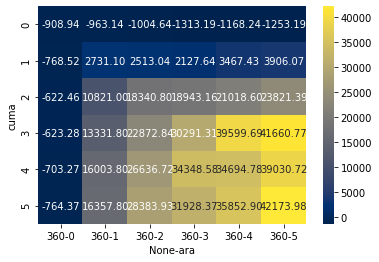

In [9]:
fluo = df.iloc[18][filter(lambda x: x.startswith('e15x32gp411'), df.iloc[18].index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')

In [ ]:
datas[0].to_csv('datasets/experiment/{}/ods.csv'.format(folder))
datas[1].to_csv('datasets/experiment/{}/fluos.csv'.format(folder))
datas[2].to_csv('datasets/experiment/{}/fluos-lower-1.csv'.format(folder))
datas[3].to_csv('datasets/experiment/{}/fluos-lower-2.csv'.format(folder))
datas[4].to_csv('datasets/experiment/{}/raw-ods.csv'.format(folder))
datas[5].to_csv('datasets/experiment/{}/raw-fluos.csv'.format(folder))
datas[6].to_csv('datasets/experiment/{}/raw-fluos-lower-1.csv'.format(folder))
datas[7].to_csv('datasets/experiment/{}/raw-fluos-lower-2.csv'.format(folder))